# PRÁCTICA NLP

La idea principal de este trabajo es determinar si se puede llegar a predecir el comportamiento de ciertas acciones en bolsa teniendo en cuenta criterios no puramente analiticos. Para ello, se llevará a cabo un analisis de sentimiento de los 25 titulares de los foros de redit mas importantes relacionados con temas bursatiles. Una vez analizados estos titulares, se introduciran las variables procesadas como features del modelo de clasificacion a entrenar. Dicho modelo intentará predecir si las acciones van a subir(label=1) o a bajar (label=0).

<img src="https://catanacapital.com/wp-content/uploads/2019/05/Market_Emotions_Cycle.png">

# Importamos las librerias que vamos a utilizar

In [1]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Datos

Contamos con dos datasets:

- 1º Combined_News_DJIA: Los 25 titulares de reddit mencionados anteriormente

- 2º upload_DJIA_table: Datos bursatiles del indice DowJones30 (open, high, close etc)

In [2]:
redit = pd.read_csv('Combined_News_DJIA.csv')#todos los titulos de foros de reddit
dj30 = pd.read_csv('upload_DJIA_table.csv')#open,high,low etc

In [3]:
dj30.shape

(1989, 7)

In [4]:
redit.shape

(1989, 27)

In [5]:
redit.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25'],
      dtype='object')

In [6]:
redit.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [7]:
dj30.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


El primer dataset lo conforman los titulares de las 25 noticias mas votadas de los foreros de redit diariamente. Hay un total de 1989 filas, lo que equivale, aproximadamente, a 8 años de historico. En este dataset está también la variable label. Esta etiqueta nos indica si el precio del indice del dowjones para ese dia subio o se mantuvo (=1) o bajó (=0).

El segundo dataset nos muestra los valores bursatiles del indice dowjones 30: precio de apertura(open), precio de cierre(close), volumen (volumne), etc.

# Limpieza de datos

In [8]:
redit.dtypes

Date     object
Label     int64
Top1     object
Top2     object
Top3     object
Top4     object
Top5     object
Top6     object
Top7     object
Top8     object
Top9     object
Top10    object
Top11    object
Top12    object
Top13    object
Top14    object
Top15    object
Top16    object
Top17    object
Top18    object
Top19    object
Top20    object
Top21    object
Top22    object
Top23    object
Top24    object
Top25    object
dtype: object

In [9]:
redit.isnull().sum()

Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64

Hay muy pocos nan. Sustituyo esos valores por  ' '

In [10]:
redit = redit.replace(np.nan, '', regex=True)

<IPython.core.display.Javascript object>

Comprobamos que los datos siguen estando muy sucios. La persona que hizo scraping no cogio solo las palabras y quedan caracteres especiales que podrian fastidiar el analisis. Sobretodo tengo que limpiar tres tipos de errores:

- b'
- b"
-  \ '

In [11]:
redit['Top1'][0]

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"'

Usamos expresiones regulares para limpiar los datos

In [12]:
replacements = [
    ("b[(')]", ''),
    ('b[(")]', ''),
    ('(\')', '')    
]

clean=redit['Top1'][0]
for old, new in replacements:
    clean = re.sub(old, new, clean)
    
clean

'Georgia downs two Russian warplanes as countries move to brink of war"'

incorporamos dicha correccion y pasamos todo a minusculas en el dataset redit.

In [13]:
for column in range(2,redit.shape[1]):
    for i in range(redit.shape[0]):
        for old, new in replacements:
            try:
                redit.iloc[i,column] = re.sub(old, new, redit.iloc[i,column].lower())
            except:
                continue
        

In [14]:
redit.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,georgia downs two russian warplanes as countri...,breaking: musharraf to be impeached.,russia today: columns of troops roll into sout...,russian tanks are moving towards the capital o...,"afghan children raped with impunity, u.n. offi...",150 russian tanks have entered south ossetia w...,"breaking: georgia invades south ossetia, russi...",the enemy combatent trials are nothing but a s...,...,georgia invades south ossetia - if russia gets...,al-qaeda faces islamist backlash,"condoleezza rice: ""the us would not act to pre...",this is a busy day: the european union has ap...,"georgia will withdraw 1,000 soldiers from iraq...",why the pentagon thinks attacking iran is a ba...,caucasus in crisis: georgia invades south ossetia,indian shoe manufactory - and again in a seri...,visitors suffering from mental illnesses banne...,"no help for mexicos kidnapping surge"""
1,2008-08-11,1,why wont america and nato help us? if they won...,bush puts foot down on georgian conflict,jewish georgian minister: thanks to israeli tr...,georgian army flees in disarray as russians ad...,"olympic opening ceremony fireworks faked""",what were the mossad with fraudulent new zeala...,russia angered by israeli military sale to geo...,an american citizen living in s.ossetia blames...,...,israel and the us behind the georgian aggression?,"""do not believe tv, neither russian nor georgi...",riots are still going on in montreal (canada) ...,china to overtake us as largest manufacturer,war in south ossetia [pics],israeli physicians group condemns state torture,russia has just beaten the united states over...,perhaps *the* question about the georgia - rus...,russia is so much better at war,so this is what its come to: trading sex for f...
2,2008-08-12,0,remember that adorable 9-year-old who sang at ...,"russia ends georgia operation""","""if we had no sexual harassment we would have ...",al-qaeda is losing support in iraq because of ...,ceasefire in georgia: putin outmaneuvers the west,why microsoft and intel tried to kill the xo $...,stratfor: the russo-georgian war and the balan...,im trying to get a sense of this whole georgia...,...,u.s. troops still in georgia (did you know the...,why russias response to georgia was right,"gorbachev accuses u.s. of making a ""serious bl...","russia, georgia, and nato: cold war two",remember that adorable 62-year-old who led you...,war in georgia: the israeli connection,all signs point to the us encouraging georgia ...,christopher king argues that the us and nato a...,america: the new mexico?,bbc news | asia-pacific | extinction by man no...
3,2008-08-13,0,u.s. refuses israel weapons to attack iran: r...,when the president ordered to attack tskhinval...,israel clears troops who killed reuters camer...,"britain\s policy of being tough on drugs is ""p...",body of 14 year old found in trunk; latest (ra...,china has moved 10 *million* quake survivors i...,bush announces operation get all up in russias...,russian forces sink georgian ships,...,elephants extinct by 2020?,us humanitarian missions soon in georgia - if ...,"georgias ddos came from us sources""","russian convoy heads into georgia, violating t...",israeli defence minister: us against strike on...,gorbachev: we had no choice,witness: russian forces head towards tbilisi i...,quarter of russians blame u.s. for conflict: ...,georgian president says us military will take...,2006: nobel laureate aleksander solzhenitsyn a...
4,2008-08-14,1,all the experts admit that we should legalise ...,war in south osetia - 89 pictures made by a ru...,swedish wrestler ara abrahamian throws away me...,russia exaggerated the death toll in south oss...,missile that killed 9 inside pakistan may have...,rushdie condemns random houses refusal to publ...,poland and us agree to missle defense deal. in...,"will the russians conquer tblisi? bet on it, n...",...,bank analy

# Analisis de sentimiento

Empiezo el analisis de sentimiento con **vader** y **TextBlob**, determinando positividad, negatividad, neutralidad, polaridad y subjetividad.

TextBlob devuelve la polaridad y subjetividad de una frse. La polaridad se encuentra entre [-1,1], -1 define un sentimiento negativo y 1 define un sentimiento positivo. Las palabras de negación invierten la polaridad. TextBlob tiene etiquetas semánticas que ayudan con el análisis detallado. Por ejemplo: emoticonos, signos de exclamación, emojis, etc. La subjetividad se encuentra entre [0,1], esta cuantifica la cantidad de opiniones personales e información fáctica contenida en el texto. La subjetividad más alta significa que el texto contiene opiniones personales en lugar de información fáctica. 

Lo que hacemos primero es quedarnos con las variables que queremos analizar (los titulares), creando el dataset sentiment_vader

In [15]:
sid = SentimentIntensityAnalyzer() #instancio el objeto sentimentAnalyzer

In [16]:
sentiment_vader=pd.DataFrame()

In [17]:
columnas_vader=redit.columns
columnas_vader=columnas_vader[2:]
sentiment_vader=redit[columnas_vader]

In [18]:
sentiment_vader.shape

(1989, 25)

In [19]:
vader_neg=pd.DataFrame()
vader_pos=pd.DataFrame()
vader_neu=pd.DataFrame()
vader_tot=pd.DataFrame()
vader_pol=pd.DataFrame()
vader_sub=pd.DataFrame()

for column in range(sentiment_vader.shape[1]):
    neg=[]
    pos=[]
    neu=[]
    tot=[]
    pol=[]
    sub=[]
    
    for i in range(sentiment_vader.shape[0]):
        try:
            neg.append(sid.polarity_scores(sentiment_vader.iloc[i,column])['neg'])
            pos.append(sid.polarity_scores(sentiment_vader.iloc[i,column])['pos'])
            neu.append(sid.polarity_scores(sentiment_vader.iloc[i,column])['neu'])
            tot.append(sid.polarity_scores(sentiment_vader.iloc[i,column])['compound'])
            pol.append(TextBlob(sentiment_vader.iloc[i,column]).sentiment.polarity)
            sub.append(TextBlob(sentiment_vader.iloc[i,column]).sentiment.subjectivity)
        
        except:
            continue
    
    
    vader_neg[columnas_vader[column]+'neg']=neg
    vader_pos[columnas_vader[column]+'pos']=pos
    vader_neu[columnas_vader[column]+'neu']=neu
    vader_tot[columnas_vader[column]+'tot']=tot
    vader_pol[columnas_vader[column]+'pol']=pol
    vader_sub[columnas_vader[column]+'pol']=sub


In [20]:
vader_neg.head()

,Top1neg,Top2neg,Top3neg,Top4neg,Top5neg,Top6neg,Top7neg,Top8neg,Top9neg,Top10neg,...,Top16neg,Top17neg,Top18neg,Top19neg,Top20neg,Top21neg,Top22neg,Top23neg,Top24neg,Top25neg
0,0.262,0.000,0.172,0.247,0.424,0.000,0.149,0.107,0.246,0.328,...,0.196,0.000,0.078,0.092,0.112,0.351,0.406,0.140,0.650,0.247
1,0.000,0.277,0.000,0.240,0.000,0.225,0.320,0.134,0.310,0.324,...,0.239,0.178,0.391,0.000,0.494,0.643,0.169,0.247,0.323,0.000
2,0.169,0.000,0.497,0.254,0.000,0.320,0.328,0.140,0.000,0.485,...,0.000,0.000,0.198,0.394,0.289,0.438,0.000,0.074,0.000,0.000
3,0.500,0.249,0.417,0.073,0.163,0.000,0.000,0.000,0.085,0.000,...,0.000,0.000,0.000,0.368,0.169,0.355,0.000,0.439,0.177,0.194
4,0.000,0.302,0.000,0.412,0.281,0.346,0.000,0.231,0.412,0.255,...,0.406,0.000,0.302,0.315,0.000,0.293,0.394,0.181,0.573,0.000


De esta forma me quedan 6 dataframes diferentes. En cada uno se analiza la positividad, negtividad, neutralidad,'compound', polaridad y subjetividad de los textos.

Lo que quiero conseguir es la media ponderada de la positividad, negatividad o neutralidad. Para ello tengo que definir unos pesos. Los pesos van de 25 a 1 (25 es el número de titulares por día) en funcion del numero en el top de importancia. De esta forma el top 1 tiene peso 25 y el top 25 tiene peso 1.

In [21]:
pesos=list(range(1,26))
pesos=pesos[::-1]
pesos[0]

25

Pondero los pesos y transformo los dataframes anteriores en uno solo llamado resultados

In [22]:
resultados=pd.DataFrame()
resultados['negatividad'] = vader_neg.mul(pesos, axis=1).sum(axis=1)/sum(pesos)
resultados['positividad'] = vader_pos.mul(pesos, axis=1).sum(axis=1)/sum(pesos)
resultados['neutralidad'] = vader_neu.mul(pesos, axis=1).sum(axis=1)/sum(pesos)
resultados['total'] = vader_tot.mul(pesos, axis=1).sum(axis=1)/sum(pesos)
resultados['polaridad'] = vader_pol.mul(pesos, axis=1).sum(axis=1)/sum(pesos)
resultados['subjetividad'] = vader_sub.mul(pesos, axis=1).sum(axis=1)/sum(pesos)
resultados.head()

,negatividad,positividad,neutralidad,total,polaridad,subjetividad
0,0.190154,0.021237,0.788625,-0.368780,-0.040314,0.163685
1,0.165105,0.091188,0.743665,-0.094385,0.034991,0.202921
2,0.195689,0.050437,0.753865,-0.318394,-0.062091,0.377127
3,0.150452,0.041649,0.807951,-0.197096,0.001742,0.176371
4,0.181422,0.094557,0.723985,-0.205634,0.047797,0.319615


Añado a este dataframe la fecha y la label 

In [23]:
df_final=redit.iloc[:,0:2]
df_final = df_final.join(resultados,how='outer')
df_final.head()

,Date,Label,negatividad,positividad,neutralidad,total,polaridad,subjetividad
0,2008-08-08,0,0.190154,0.021237,0.788625,-0.368780,-0.040314,0.163685
1,2008-08-11,1,0.165105,0.091188,0.743665,-0.094385,0.034991,0.202921
2,2008-08-12,0,0.195689,0.050437,0.753865,-0.318394,-0.062091,0.377127
3,2008-08-13,0,0.150452,0.041649,0.807951,-0.197096,0.001742,0.176371
4,2008-08-14,1,0.181422,0.094557,0.723985,-0.205634,0.047797,0.319615


Quiero que mi modelo predictivo tambien cuente con features como el precio de la accion o el volumen, por eso uno este dataset con el del DJ30. Como luego compararé que modelo sale mejor, el que incluye al precio y a variables 'objetivas' o al que solo incluye variables 'subjetivas', defino este modelo como df_final_2

In [24]:
df_final_2=df_final.merge(dj30, how='inner', on = 'Date', left_index=True)
df_final_2.head()

,Date,Label,negatividad,positividad,neutralidad,total,polaridad,subjetividad,Open,High,Low,Close,Volume,Adj Close
1988,2008-08-08,0,0.190154,0.021237,0.788625,-0.368780,-0.040314,0.163685,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312
1987,2008-08-11,1,0.165105,0.091188,0.743665,-0.094385,0.034991,0.202921,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609
1986,2008-08-12,0,0.195689,0.050437,0.753865,-0.318394,-0.062091,0.377127,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727
1985,2008-08-13,0,0.150452,0.041649,0.807951,-0.197096,0.001742,0.176371,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961
1984,2008-08-14,1,0.181422,0.094557,0.723985,-0.205634,0.047797,0.319615,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688


In [25]:
df_final_2.isnull().any()

Date            False
Label           False
negatividad     False
positividad     False
neutralidad     False
total           False
polaridad       False
subjetividad    False
Open            False
High            False
Low             False
Close           False
Volume          False
Adj Close       False
dtype: bool

# Modelo predictivo de clasificación

Comienzo el analisis predictivo con un clasificador simple para tener un resultado base a mejorar. Para ello uso un kvecinos. Se empieza el analisis con el dataframe que **no** incluye informacion bursatil, solo analisis de sentimiento.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [27]:
X=df_final.drop(['Label','Date'],axis=1)
y=df_final['Label']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [30]:
pred= classifier.predict(X_test)


In [31]:
classifier.score(X_test,y_test)

0.5053272450532724

Probamos ahora con un modelo un poco mas robusto. En este caso el LGBMClassifier

In [32]:
from lightgbm import LGBMClassifier

In [33]:
model_lgb = LGBMClassifier()

In [34]:
model_lgb.fit(X_train, y_train)

LGBMClassifier()

In [35]:
model_lgb.score(X_test,y_test)

0.5144596651445966

Realizamos una busqueda de metaparametros intentando mejorar el modelo.

In [36]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['test'],
            'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm 

from sklearn.model_selection import RandomizedSearchCV

param_test ={'num_leaves': sp_randint(6, 1500), 
             'max_depth': sp_randint(3,20),
             'min_child_weight': sp_randint(10, 250)}

n_HP_points_to_test = 30

clf = LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4,n_estimators=2000)

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='accuracy',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

gs.fit(X_train, y_train, **fit_params)

print('Mejor score alcanzado: {} con los parametros: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training un

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	test's auc: 0.544607
Early stopping, best iteration is:
[71]	test's auc: 0.550624
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	test's auc: 0.5
Training until validation scores don't 

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.6s finished


In [37]:
model_lgb = LGBMClassifier(n_estimators=200,
                         num_leaves=860,
                         max_depth=11,
                         min_child_weight=119)

model_lgb.fit(X_train, y_train)
model_lgb.score(X_test,y_test)

0.5372907153729072

Pese a haber hecho una busqueda de metaparametros y haber utilizado un modelo mas robusto como el el LGBM seguimos teniendo un score bastante bajo(~0.5). Para mejorar el modelo vamos a utilizar tambien datos bursatiles 

In [38]:
X=df_final_2.drop(['Label','Date','Adj Close'],axis=1)#quito el cierre ajustado tambien. me quedo solo con el cierre 'close'
y=df_final['Label']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [40]:
X_train.head()

,negatividad,positividad,neutralidad,total,polaridad,subjetividad,Open,High,Low,Close,Volume
1608,0.125828,0.057083,0.817086,-0.183346,0.034436,0.230929,10037.849609,10161.570312,9976.709961,10144.190430,194470000
88,0.145483,0.025868,0.828662,-0.320976,-0.010479,0.220251,16712.699219,16795.980469,16623.910156,16639.970703,98480000
309,0.092677,0.042286,0.865055,-0.121154,-0.000759,0.225032,18052.320312,18107.570312,17974.810547,17977.039062,120090000
1904,0.113326,0.071837,0.814963,-0.075727,0.031778,0.220058,8637.650391,9026.410156,8637.490234,8934.179688,358970000
320,0.151966,0.055449,0.792538,-0.129773,0.029822,0.196389,17716.269531,17759.509766,17579.269531,17678.230469,117740000


Volvemos a intentar el mismo problema de clasificacion pero con el dataset modificado.

In [41]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [42]:
pred= classifier.predict(X_test)
classifier.score(X_test,y_test)

0.4657534246575342

El score sigue saliendo bajo, probamos con otro modelo simple de clasificacion como es el de discriminacion lineal

In [43]:
model = LinearDiscriminantAnalysis()

In [44]:
model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [45]:
pred= model.predict(X_test)
model.score(X_test,y_test)

0.9360730593607306

In [46]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       296
           1       0.91      0.98      0.94       361

    accuracy                           0.94       657
   macro avg       0.94      0.93      0.93       657
weighted avg       0.94      0.94      0.94       657



Este modelo parece adaptarse muy bien al dataset y da un acuracy alto(0.93), además no tiene hiperparametros que tunear.

Cross validation del modelo anterior

In [47]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model,X, y, cv=5)

In [48]:
display(scores,scores.mean())

array([0.95728643, 0.91959799, 0.90954774, 0.92462312, 0.94710327])

0.9316317101882208

Probamos ahora con una red neuronal

Preprocesamos los datos, dejando la mu=0 y la desviacion =1

In [59]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train= sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [60]:
import keras
from keras.models import Sequential#inicializa la red
from keras.layers import Dense,Dropout,BatchNormalization#agrega capas a la red

Instanciamos el objeto clasificador(de tipo secuencial) y definimos la arquitectura de la red.

In [61]:
clasificador= Sequential()

clasificador.add(Dense(units=100, kernel_initializer ='uniform', activation = 'relu', input_dim=X_train.shape[1]))
clasificador.add(Dropout(0.2))
clasificador.add(BatchNormalization())
clasificador.add(Dense(units=50, activation = 'relu'))
clasificador.add(Dropout(0.2))
clasificador.add(Dense(units=1, activation = 'sigmoid'))

clasificador.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=clasificador.fit(X_train, y_train, batch_size=100, epochs=150, validation_split=0.15,callbacks=[tf.keras.callbacks.EarlyStopping(patience=40, mode='min', monitor= 'val_loss')])

<IPython.core.display.Javascript object>

Epoch 1/150
12/12 [==============================] - 1s 14ms/step - loss: 0.7655 - accuracy: 0.5232 - val_loss: 0.6915 - val_accuracy: 0.5300
Epoch 2/150
12/12 [==============================] - 0s 4ms/step - loss: 0.7509 - accuracy: 0.5283 - val_loss: 0.6928 - val_accuracy: 0.4700
Epoch 3/150
12/12 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5535 - val_loss: 0.6925 - val_accuracy: 0.5400
Epoch 4/150
12/12 [==============================] - 0s 4ms/step - loss: 0.7037 - accuracy: 0.5729 - val_loss: 0.6921 - val_accuracy: 0.5200
Epoch 5/150
12/12 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5713 - val_loss: 0.6915 - val_accuracy: 0.5050
Epoch 6/150
12/12 [==============================] - 0s 5ms/step - loss: 0.6800 - accuracy: 0.5924 - val_loss: 0.6926 - val_accuracy: 0.4850
Epoch 7/150
12/12 [==============================] - 0s 5ms/step - loss: 0.6819 - accuracy: 0.5735 - val_loss: 0.6918 - val_accuracy: 0.5150
Epoch 8/150


La red neuronal tiene la siguiente arquitectura:

In [62]:
clasificador.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               1200      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 6,701
Trainable params: 6,501
Non-trainable params: 200
__________________________________________________

Para comprobar que no estamos haciendo overfitting del modelo pintamos en una grafica la evolucion del error en validacion y en entrenamiento.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

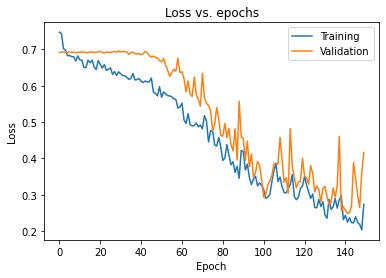

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [54]:
y_pred = clasificador.predict(X_test)
y_pred = (y_pred>0.5)

Calculamos el score y la matriz de confusion para ver que tal los resultados obtenidos con la red.

In [55]:
from sklearn.metrics import confusion_matrix
mc= confusion_matrix(y_test,y_pred)

In [56]:
mc

array([[107, 189],
       [ 98, 263]])

In [57]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.563165905631659

La red neuronal, pese a ser un modelo mucho mas robusto que el de discriminacion lineal, no consigue dar resultados tan buenos, quedando una accuracy final de 0.86.

# Conclusiones

Una vez visto los resultados se pueden llegar a ciertas conclusiones.

- No es tan sencillo predecir la evolución de los precios de una accion o indice solo por analisis de sentimiento, es necesario añadir otra informacion.

- Por otro lado, si que se puede usar esa informacion para enriquecer el modelo y se puede llegar a resultados buenos

- Modelos simples como el de LinearDiscriminantAnalysis parecen dar mejores resultados que modelos mas robustos como una red neuronal o el LGBM

# Cosas a mejorar

Se dejan ciertas opciones de mejora a implementar a futuro:
    
- Se pueden añadir nuevas features en el modelo como por ejemplo indicadores de analisis tecnico.

- No se ha tenido en cuenta la temporalidad de la serie. Se podria tener en cuenta el precio o la positividad en dias anteriores con algoritmos que si tienen 'memoria' como las redes LSTM